In [1]:
import numpy as np

In [2]:
def resist(p0, alfa, T):
    
    # T ~ °C
    
    return p0 * (1 + alfa*(T - 25))

In [17]:
p0, alfa = 1.67e-6, 0.0043
T1, T2 = 400, -100

[1/ ( resist(p0, alfa, Ti)/100 ) for Ti in [T1, T2]]

[22920665.845342807, 129470788.15342289]

In [16]:
[resist(p0, alfa, Ti)/100 for Ti in [T1, T2]]

[4.362875e-08, 7.72375e-09]

In [18]:
p0, alfa = 6.84e-6, 0.0069
T1, T2 = -50, 500

[1/resist(p0, alfa, Ti)*100 for Ti in [T1, T2]]

[30300275.732509162, 3417856.935344401]

In [23]:
p0, alfa = 6.84e-6, 0.0069
T1, T2 = -50, 500

[(resist(p0, alfa, Ti)/100) for Ti in [T1, T2]]

[3.3003e-08, 2.9258099999999996e-07]

In [1]:
# Import the libraries we need for this lab

import pandas as pd
# Allows us to use arrays to manipulate and store data
import numpy as np
# PyTorch Library
import torch
# PyTorch Neural Network
import torch.nn as nn
# Allows us to use activation functions
import torch.nn.functional as F
# Used to graph data and loss curves
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap
# Used to help create the dataset and perform mini-batch
from torch.utils.data import Dataset, DataLoader

import torchvision.transforms as transforms

from sklearn.preprocessing import StandardScaler as ss, MinMaxScaler as mms, LabelEncoder as le, OneHotEncoder as ohe

from IPython.display import clear_output
import json

---

Main Objective:

<p> Measure how much is the first consumption of a drug determined by psychological and socioeconomic factors. In other words, how well psychological and socioeconomic factors can predict wether a person has ever experimented with drugs or not.<\p[>

---

# Torch Dataset Class

In [2]:
# Define the class XOR_Data

class Load_Data(Dataset):
    
    # Constructor
    # N_s is the size of the dataset
    def __init__(self, x, y):
        
        # Create a N_s by 2 array for the X values representing the coordinates
        self.x = torch.Tensor(x)
        # Create a N_s by 1 array for the class the X value belongs to
        self.y = torch.Tensor(y)
    
        self.len = y.size

    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot_2d(self, xy=[0,1], alpha=0.5, figsize=(4,2)):
        
        fig = plt.figure(figsize=figsize); ax=fig.add_subplot(1,1,1)
        
        ax.plot(self.x[self.y[:, 0] == 0, xy[0]].numpy(),
                 self.x[self.y[:, 0] == 0, xy[1]].numpy(), 'o', label="y=0", alpha=alpha)
        ax.plot(self.x[self.y[:, 0] == 1, xy[0]].numpy(),
                 self.x[self.y[:, 0] == 1, xy[1]].numpy(), 'ro', label="y=1", alpha=alpha)
        plt.legend(); plt.grid(); plt.show()
    
    def plot_3d(self, xyz=[0,1,2], angles=range(0, 360, 12), angle_factor=8, alpha=0.6, figsize=(6,4)):
        
        for angle in angles:
            
            fig = plt.figure(figsize=figsize)
            ax = fig.add_subplot(projection='3d')
            ax.scatter(self.x[self.y[:, 0]==0, xyz[0]],
                       self.x[self.y[:, 0]==0, xyz[1]],
                       self.x[self.y[:, 0]==0, xyz[2]], 'o', alpha=alpha)

            ax.scatter(self.x[self.y[:, 0]==1, xyz[0]],
                       self.x[self.y[:, 0]==1, xyz[1]],
                       self.x[self.y[:, 0]==1, xyz[2]], 'ro', alpha=alpha)

            fig.tight_layout()
            
            ax.view_init(angle/angle_factor, angle)
            plt.show()
            plt.pause(0.001)
            clear_output(wait=True)
 

# Torch Neural Network Classes

In [3]:
# Define the class Net with one hidden layer 

class Shallow_NN(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H, D_out):
        super(Shallow_NN, self).__init__()
        # D_in is the input size of the first layer (size of input layer)
        # H is the output size of the first layer and the input size of the second layer (size of hidden layer)
        # D_out is the output size of the second layer (size of output layer)
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)

    # Prediction    
    def forward(self, x):
        # Puts x through first layer then sigmoid function
        x = torch.sigmoid(self.linear1(x)) 
        # Puts result of previous line through second layer then sigmoid function
        x = torch.sigmoid(self.linear2(x))
        # Output is a number between 0 and 1 due to the sigmoid function. Whichever the output is closer to, 0 or 1, is the class prediction
        return x

### Neural Net with "N" Hidden Layer

In [143]:
[8][:-1],[8][1:]

([], [])

In [190]:
class Deep_NN(nn.Module):
    
    # Constructor
    # Given a list of integers, Layers, we create layers of the neural network where each integer in Layers corresponds to the layers number of neurons
    def __init__(self, Layers):
        
        super(Deep_NN, self).__init__()
        
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers[:-1], Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    # Puts the X value through each layer of the neural network while using the RELU activation function in between. The final output is not put through RELU.
    def forward(self, x, activation='sigmoid'):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            
            if l < L - 1:                
                if activation=='relu': x = F.relu(linear_transform(x))    
                elif activation=='sigmoid': x = torch.sigmoid(linear_transform(x))    

            else: x = torch.sigmoid(linear_transform(x))
        
        return x

# Calculate the accuracy of prediction

def accuracy(model, dataset):
    # Rounds prediction to nearest integer 0 or 1
    # Checks if prediction matches the actual values and returns accuracy rate
    return np.mean(data_set.y.view(-1).numpy() == (model(data_set.x)[:, 0] > 0.5).numpy())

In [5]:
from sklearn.metrics import accuracy_score as acc_scr

def accuracy(model, dataset):
    
    return acc_scr( dataset.y.view(-1).numpy(), ((model(dataset.x)>0.5)+0).numpy() )

Define a function to train the model:


In [290]:
np.array([0,2,3])==2

array([False,  True, False])

In [304]:
np.random.choice([0,1,2,4,5,12,12,13,15])

2

In [546]:
# Function to Train the Model

def train(train_data, model, criterion, train_loader, optimizer, activation='sigmoid', epochs=5, test_data=None, plot=False, return_model=False, accuracy=None):
    
    if len(np.unique(train_data.y))>2: multi_class=True
    
    COST = []; ACC = []; test_ACC = []
    for epoch in range(epochs):
        
        if epoch in range(9, epochs, 10): 
            clear_output(wait=True); print(f'Epoch: {epoch+1}/{epochs}')        
        
        total_loss=0
        for x, y in train_loader:
            
            optimizer.zero_grad()
            
            yhat = model(x, activation=activation)
            if multi_class: y = torch.LongTensor(y.numpy().reshape(-1))
#            return y, yhat
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        ACC.append(accuracy(model, train_data))
        COST.append(total_loss)

# ------------------ Validation Data ---------

        if type(test_data)!=type(None): test_ACC.append(accuracy(model, test_data))    
        
# ------------ Result Visualization -------------

    if plot:
        
        fig = plt.figure(figsize=(8, 2.5))
        
        # Prints Cost vs Epoch graph
        #fig = plt.figure(figsize=(4.75,2.5)); 
        ax1 = fig.add_subplot(1,2,1)
        color = 'tab:red'
        ax1.plot(COST, color=color)
        ax1.set_xlabel('epoch', color=color)
        ax1.set_ylabel('total loss', color=color)
        ax1.tick_params(axis='y', color=color)

        # Prints Accuracy vs Epoch graph
        ax2 = ax1.twinx()  
        color = 'tab:blue'
        ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
        ax2.plot(ACC, color=color)
        ax2.tick_params(axis='y', color=color)

        if type(test_data)!=type(None):

            #fig2 = plt.figure(figsize=(4,2.5)); 
            ax3 = fig.add_subplot(1,2,2)
            color = 'tab:green'
            ax3.plot(test_ACC, color=color)
            ax3.set_xlabel('epoch', color=color)
            ax3.set_ylabel('test_acc', color=color)
            ax3.tick_params(axis='y', color=color)
            #fig2.tight_layout()

        fig.tight_layout()  # otherwise the right y-label is slightly clipped
        plt.show()
    
    if return_model: return model
    
    return COST, ACC, test_ACC

array([4., 3., 3., ..., 0., 6., 5.], dtype=float32)

In [427]:
def multi_class_select(yhat):
    
    array = []
    
    for i in range(len(yhat)):
        
        row=yhat[i].detach().numpy()
        is_max = row==max(row)
        
        if sum(is_max)>1: 
        
            series = pd.Series(is_max)
            array.append( np.random.choice( series[series==True].index.tolist() ) )
        
        else: 
            
            array.append(   list(row).index(max(row)) )
    
    return torch.tensor(array)

In [529]:
def multiclass_accuracy(model, train_data):
    
    return acc_scr( multi_class_select( model(train_data.x) ), train_data.y)

In [389]:
y, yhat = comp_lst[0]

In [428]:
loss = nn.CrossEntropyLoss()

In [447]:
multi_class_select(yhat)#.reshape(-1,1)

tensor([6, 6, 6,  ..., 6, 6, 6])

In [490]:
trgt = y.reshape(-1)

trgt = torch.LongTensor ( np.array( [int( i.item() ) for i in trgt] ) )

In [491]:
input_= multi_class_select(yhat).reshape(-1,1)

In [495]:
loss(yhat, trgt)

tensor(1.9387, grad_fn=<NllLossBackward>)

In [ ]:
# Plot the data

def plot_decision_regions_2class(model,data_set ,index=[0,1]):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, index[0]].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, index[1]].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

    yhat = np.logical_not((model(XX)[:, 0] > 0.5).numpy()).reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, shading='auto')
    plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], 'o', label='y=0')
    plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], 'ro', label='y=1')
    #plt.title("decision region")
    plt.legend()

In [8]:
def binary_train_test_split( X, Y, training=[100,100], testing=[100,100],
                         fill_train_1=False, equal_train_0=False,
                         replace=False, return_index=False, report=True
                       ):
    
    idx_0, idx_1 = Y[Y==0].index.copy(), Y[Y==1].index.copy()

    test_0 = list(np.random.choice( idx_0, testing[0], replace=replace ))
    test_1 = list(np.random.choice( idx_1, testing[1], replace=replace ))

    idx_0 = list( set(idx_0).difference(test_0) )
    idx_1 = list( set(idx_1).difference(test_1) )
    
    if fill_train_1: training[1] = len(idx_1)
    if equal_train_0: training[0] = training[1]
        
    train_0 = list(np.random.choice( idx_0, training[0], replace=replace ))
    train_1 = list(np.random.choice( idx_1, training[1], replace=replace ))

    test_index = test_0 + test_1
    train_index = train_0 + train_1
    
    X_train = X.loc[train_index]; X_test = X.loc[test_index]
    Y_train = Y.loc[train_index]; Y_test = Y.loc[test_index]

    report_df = pd.concat(map(pd.value_counts, [Y_train, Y_test]), 1)
    report_df.columns=['Train Set', 'Test Set']; report_df.index.name='class';
    if report: display(report_df)
    
    if return_index:
        return train_index, test_index
    
    return X_train, X_test, Y_train, Y_test

In [9]:
def split(X, Y, subclass_size, report=True, return_index=False):

    test_size = int( Y[Y==1].shape[0] * subclass_size)
    
    return binary_train_test_split( 
                                     X, Y, 
                                     training=[None, None], testing=[test_size, test_size],
                                     fill_train_1=True, equal_train_0=True,
                                     replace=False, return_index=return_index, report=report
                                 )

In [10]:
def binary_target(series, classes, name, norm=False):
    
    Y = series.apply(lambda clss: int(clss not in classes)) # 0 if never used else 1
    
    if Y[Y==1].sum()>Y[Y==0].sum(): 
        Y = Y.apply(lambda x: int(not x))
        print('Classes Inverted: The inputted classes represent the minority class (class 1).')   
            
    if norm: Y = Y.apply(lambda x: ( x - Y.mean() ) / y.std())
    
    Y.name = name
    return Y

In [108]:
def Build_Layers(Dataset, hidden_layers=[5,5,5]):
    
    n_categories = len( np.unique(Dataset.y) )
    
    input_layer = Dataset.x.shape[1] # n_features
    output_layer = n_categories if n_categories!=2 else n_categories-1

    return [input_layer] + hidden_layers + [output_layer]


In [12]:
def initialize_parameters(model, weight=0, bias=0):
       
    keys = list( model.state_dict().keys() )
    shapes = [model.state_dict()[key].shape for key in keys]    
    
    cnt = 0
    for key, shape in zip(keys, shapes):
        cnt += 1
        model.state_dict()[key][:] = weight if cnt%2 != 0 else bias
        
    return model

In [505]:
def execute_neural_net(X, Y, test_size=0.3, split_index=None,
                       
                       hidden_layers = [36,36,36],
                       initial_params = {'weight':0, 'bias':0},
                       
                       criterion=nn.BCELoss, 
                       optimizer=torch.optim.SGD,
                       activation='sigmoid',
                       accuracy=None,
                       
                       epochs=500,
                       batch_size=30,
    
                       lr=0.1,
                       momentum=0,
                       
                       clear=False):

    ### --------------- Loading Train and Test Torch Datasets -------------------------------

    if type(split_index)==type(None):
        
        x_train, x_test, y_train, y_test = split(X, Y, test_size)
    else:
        
        train_idx, test_idx = split_index
        x_train, x_test, y_train, y_test = X.loc[train_idx].copy(), X.loc[test_idx].copy(), Y[train_idx].copy(), Y[test_idx].copy()
    
    train_data = Load_Data(x_train.values, y_train.to_frame().values)
    test_data = Load_Data(x_test.values, y_test.to_frame().values)
    
 
    ### ------------------------- Model Settings -------------------------------

    torch.manual_seed(1)

    Layers = Build_Layers(train_data, hidden_layers)
    
    model = Deep_NN(Layers)


    ### ---------------------------- Initialization Parameters: Manual Setting --------------------
    
#    if type(initial_params)!=type(None):  
#        initial_params['model'] = model
#        model = initialize_parameters( **initial_params )    
 
    #keys = list( model.state_dict().keys() )
    #shapes = [ model.state_dict()[key].shape for key in keys ]    
    #weight, bias = 0, 0
    
#    for i, (key, shape) in enumerate(zip(keys, shapes)):
#        model.state_dict()[key][:] = (weight if i%2 == 0 else bias)
#        model.state_dict()[key].requires_grad=True

    ### ------------------------------ Criterion, Optimizer and Train Loader ------------------------------

    criterion = criterion()
    optimizer = optimizer(model.parameters(), lr=lr, momentum=momentum)
    train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
    
    
    ###  ----------------------------------------- Training Model Parameters -------------------------

    
    LOSS, ACC, test_ACC = train(
                                    train_data=train_data, model=model,
                                    criterion=criterion, train_loader=train_loader, optimizer=optimizer,
                                    epochs=epochs, test_data=test_data, accuracy=accuracy
                                )
    
    if clear: clear_output(wait=False)
    
    return (LOSS, ACC, test_ACC)

---

# LOADING CLEAN DATA

In [122]:
data = pd.read_csv('data/drug_use_clean.csv')

socio = data.columns[:6].tolist()
psych = data.columns[6:13].tolist()
drugs = data.columns[13:].tolist()

#### Categories Dictionary

In [123]:
drug_cls = json.loads( open('DrugConsumptionClasses.json', 'r').read() )
socio_cls = json.loads( open('SocioeconomicClasses.json', 'r').read() )

In [125]:
drug_cls

{'CL0': 'Never Used',
 'CL1': 'Used over a Decade Ago',
 'CL2': 'Used in Last Decade',
 'CL3': 'Used in Last Year',
 'CL4': 'Used in Last Month',
 'CL5': 'Used in Last Week',
 'CL6': 'Used in Last Day'}

In [124]:
data

,ID,Age,Gender,Education,Country,Ethnicity,Nscore,Escore,Oscore,Ascore,...,Ecstasy,Heroin,Ketamine,Legalh,LSD,Meth,Mushrooms,Nicotine,Semer,VSA
0,2,25-34,Male,Doctorate degree,UK,White,-0.67825,1.93886,1.43533,0.76096,...,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
1,3,35-44,Male,Professional certificate/ diploma,UK,White,-0.46725,0.80523,-0.84732,-1.62090,...,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
2,4,18-24,Female,Masters degree,UK,White,-0.14882,-0.80615,-0.01928,0.59042,...,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
3,5,35-44,Female,Doctorate degree,UK,White,0.73545,-1.63340,-0.45174,-0.30172,...,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0
4,6,65+,Female,Left school at 18 years,Canada,White,-0.67825,-0.30033,-1.55521,2.03972,...,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL6,CL0,CL0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1879,1884,18-24,Female,"Some college or university, no certificate or ...",USA,White,-1.19430,1.74091,1.88511,0.76096,...,CL0,CL0,CL0,CL3,CL3,CL0,CL0,CL0,CL0,CL5
1880,1885,18-24,Male,"Some college or university, no certificate or ...",USA,White,-0.24649,1.74091,0.58331,0.76096,...,CL2,CL0,CL0,CL3,CL5,CL4,CL4,CL5,CL0,CL0
1881,1886,25-34,Female,University degree,USA,White,1.13281,-1.37639,-1.27553,-1.77200,...,CL4,CL0,CL2,CL0,CL2,CL0,CL2,CL6,CL0,CL0
1882,1887,18-24,Female,"Some college or university, no certificate or ...",USA,White,0.91093,-1.92173,0.29338,-1.62090,...,CL3,CL0,CL0,CL3,CL3,CL0,CL3,CL4,CL0,CL0


---

# DATA TRANSFORMATION

# Dependent Variables Definition:

### Binary Target Variable Definition

In [16]:
target = 'Cannabis'

Y = binary_target (data[target], classes = ['CL0', 'CL1', 'CL2'], name=target+' Ever', norm=False)

Classes Inverted: The inputted classes represent the minority class (class 1).


In [17]:
Y.value_counts().to_frame()

,Cannabis Ever
0,999
1,885


### Multi Class Target Variable Definition

In [18]:
Y_mc = le().fit( list(drug_cls.keys()) ).transform(data[target])
Y_mc = pd.Series(Y_mc, index=data.index, name=target)

In [19]:
Y_mc.value_counts().to_frame().reset_index().sort_values(by='index', ascending=True).set_index('index').T

index,0,1,2,3,4,5,6
Cannabis,412,207,266,211,140,185,463


# Independent variables Definition:

In [30]:
def LabelEncodeDf(df, cols=None):
    
    if cols==None: cols = df.columns
    for col in cols: df[col] = le().fit_transform( df[col] )
    return df

In [42]:
def OneHotEncodeDf(df, cols=None, drop=None):

    if type(cols)==type(None): cols = list(df.columns)
    
    encoder = ohe(sparse=False, drop=drop)
    encoded_array = encoder.fit_transform(df[cols])
    
    new_cols = []
    for col, cats in zip(cols, encoder.categories_):
        new_cols += [f'{col}-{str(cat)}' for cat in cats[(1 if drop=='first' else 0):]]
    
    encoded_data = pd.DataFrame(encoded_array, columns=new_cols)

    remaining_cols = list( set(df.columns).difference(cols) )
    if remaining_cols!=[]: 
        encoded_data = pd.concat( [encoded_data, df[remaining_cols]] , 1)
            
    return encoded_data

### Data Labeling (Numeric Conversion)

In [48]:
features = socio[1:] + psych

In [49]:
X = data[features].copy()

# Label Encoding -----------------------------
X = LabelEncodeDf(X, socio[1:])

### Data Scaling

In [50]:
X_norm = X.copy(); X_max = X.copy()

# Standard Scaling (Normalization) -----------------------------------------------
X_norm[socio[1:]] = ss().fit_transform(X_norm[socio[1:]])

# Max Scaling -----------------------------------------------
X_max[socio[1:]] = mms().fit_transform(X_max[socio[1:]])

### Data OneHot Encoding

In [51]:
X_onehot = OneHotEncodeDf(X, cols=socio[1:], drop=None)

### Additional Features

In [35]:
all_features = socio[1:] + psych + [ col for col in drugs if col !=target ]

X_full = data[all_features].copy()

label_features = list(set(all_features).difference(psych))

X_full = LabelEncodeDf(X_full, label_features)

### Additional Features OneHot Encoded

In [53]:
X_full_onehot = OneHotEncodeDf(X_full, cols=label_features, drop=None)

### All Training Data:

In [54]:
model_inputs = [X, X_norm, X_max, X_onehot, X_full, X_full_onehot]

---

# MODELING (Neural Networks)

### Binary and Multiclass Classification with Neural Networks


## Variations of Deep Learning Models:

1. Data Scaling
1. Momentum
2. Activation function
3. Criterion
5. Optimizer

# 1. Simple Binary and Multiclass Classification

### Training And Testing Split Indexes

In [55]:
split_index = split(X, Y, 0.3, return_index=True)

,Train Set,Test Set
class,,
1,620,265
0,620,265


# Data Scaling Comparison

In [56]:
comp_lst = []
params = model_inputs

for param in params:

    comp_lst.append( 
                       execute_neural_net (  param, Y, None, split_index,  ############## X #################

                       hidden_layers = [36],
                       initial_params = {'weight':0, 'bias':0},

                       criterion = nn.BCELoss, 
                       optimizer = torch.optim.SGD,

                       epochs = 1000,
                       batch_size=X_norm.shape[0],

                       lr = 0.1,
                       momentum = 0,

                       clear=False)
                     )

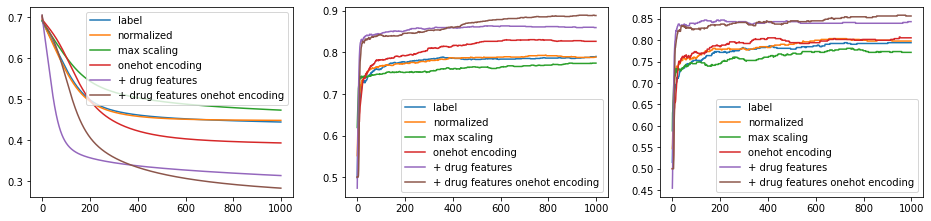

In [64]:
fig = plt.figure(figsize=(16,3.5)); axs = [fig.add_subplot(1,3,i) for i in range(1, 3+1)]
params=['label', 'normalized', 'max scaling', 'onehot encoding','+ drug features', '+ drug features onehot encoding']
for i in range(3):
    
    for df, key in zip(comp_lst, params):
        axs[i].plot(df[i], label=key)
    
    axs[i].legend()
        
clear_output(wait=True); plt.show()

# Multi-Class Data Scaling Comparison

In [552]:
comp_lst = []
params = model_inputs

for param in params:

    comp_lst.append( 
                       execute_neural_net (  param, Y_mc, None, split_index,  ############## X #################

                       hidden_layers = [X_full.shape[1] * 3],
                       initial_params = {'weight':0, 'bias':0},

                       criterion = nn.CrossEntropyLoss, 
                       optimizer = torch.optim.SGD,
                       accuracy = multiclass_accuracy,
                                           
                       epochs = 600,
                       batch_size=Y.shape[0],

                       lr = 0.1,
                       momentum = 0.5,

                       clear=False)
                     )

Epoch: 600/600


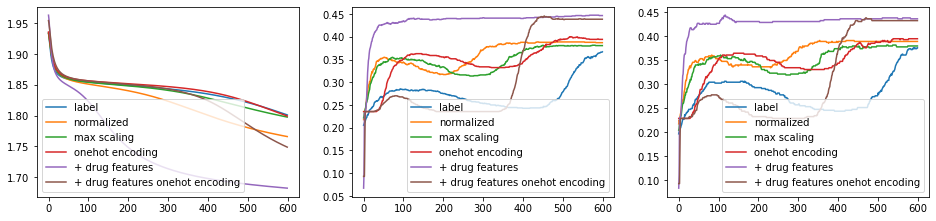

In [553]:
fig = plt.figure(figsize=(16,3.5)); axs = [fig.add_subplot(1,3,i) for i in range(1, 3+1)]
params=['label', 'normalized', 'max scaling', 'onehot encoding','+ drug features', '+ drug features onehot encoding']
for i in range(3):
    
    for df, key in zip(comp_lst, params):
        axs[i].plot(df[i], label=key)
    
    axs[i].legend()
        
clear_output(wait=True); plt.show()

# Arquitectures Comparison

In [98]:
comp_lst = []
n_feats = len(X_full.columns)
params = [[n_feats], [n_feats*3], [n_feats*9], [n_feats]*3, [n_feats*3]*3, [n_feats*9]*3, [n_feats]*9, [n_feats*3]*9, [n_feats*9]*9]

for param in params:

    comp_lst.append( 
                       execute_neural_net (  X_full, Y, None, split_index,

                       hidden_layers = param,
                       initial_params = {'weight':0, 'bias':0},

                       criterion = nn.BCELoss, 
                       optimizer = torch.optim.SGD,

                       epochs = 1000,
                       batch_size=X_norm.shape[0],

                       lr = 0.1,
                       momentum = 0,

                       clear=False)
                     )

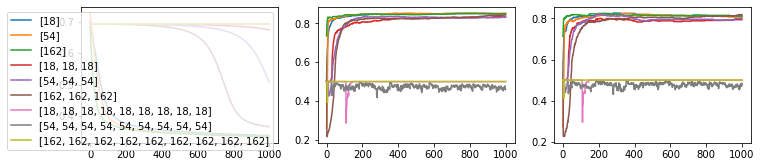

In [101]:
fig = plt.figure(figsize=(12,2.5)); axs = [fig.add_subplot(1,3,i) for i in range(1, 3+1)]

for i in range(3):
    
    for df, key in zip(comp_lst, params):
        axs[i].plot(df[i], label=key)
    
    if i==0:axs[i].legend()
        
clear_output(wait=True); plt.show()

# Momentum Comparison

In [64]:
comp_lst = []
params = [0, .1, .3, .5, .7, .9]

for param in params:

    comp_lst.append( 
                       execute_neural_net (  X_norm, Y, None, split_index,

                       hidden_layers = [1],
                       initial_params = {'weight':0, 'bias':0},

                       criterion = nn.BCELoss, 
                       optimizer = torch.optim.SGD,

                       epochs = 100,
                       batch_size=X_norm.shape[0],

                       lr = 0.1,
                       momentum = param, ####################### momentum ############

                       clear=False)
                     )

Epoch: 100/100


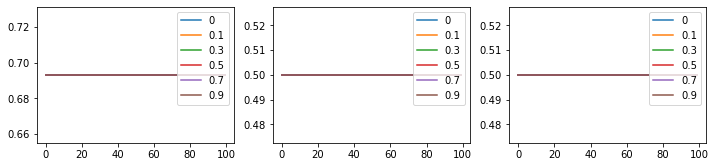

In [65]:
fig = plt.figure(figsize=(12,2.5)); axs = [fig.add_subplot(1,3,i) for i in range(1, 4)]

for i in range(3):
    
    for df, key in zip(comp_lst, params):
        axs[i].plot(df[i], label=key)
    
    axs[i].legend()
        
clear_output(wait=True); plt.show()

# Loss Function Comparison

In [1221]:
losses = [  nn.L1Loss,
            nn.MSELoss,
            nn.BCELoss,
            nn.HuberLoss  ]

In [ ]:
comp_lst = []; fail = []
params = losses

for param in params:
    
    try:
        comp_lst.append( 
                           execute_neural_net (  X_norm, Y, None, split_index,

                           hidden_layers = [1],
                           initial_params = {'weight':0, 'bias':0},

                           criterion = param, 
                           optimizer = torch.optim.SGD,

                           epochs = 1500,
                           batch_size=X_norm.shape[0],

                           lr = 0.1,
                           momentum = 0, ####################### momentum ############

                           clear=False)
                         )
    except:

        fail.append(param)

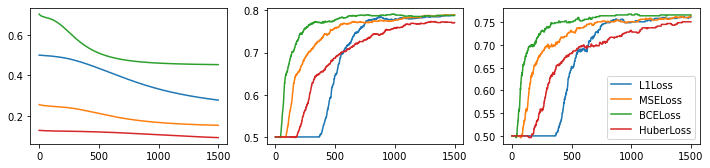

In [1225]:
fig = plt.figure(figsize=(12,2.5)); axs = [fig.add_subplot(1,3,i) for i in range(1, 4)]

for i in range(3):
    
    for df, key in zip(comp_lst, [param for param in params if param not in fail]):
        axs[i].plot(df[i], label=str(key).split('.')[-1][:-2])
    
    if i==2: axs[i].legend()
        
clear_output(wait=True); plt.show()

# Optimizer Comparison

In [1227]:
optims = [  torch.optim.Adadelta,
            torch.optim.Adagrad,
            torch.optim.Adam,
            torch.optim.AdamW,
            torch.optim.SparseAdam,
            torch.optim.Adamax,
            torch.optim.ASGD,
            torch.optim.SGD,
            torch.optim.Rprop,
            torch.optim.RMSprop,
            torch.optim.Optimizer,
            torch.optim.LBFGS,
            torch.optim.lr_scheduler,
            torch.optim.swa_utils  ]

In [ ]:
comp_lst = []; fail = []
params = optims

for param in params:
    
    try:
        comp_lst.append( 
                           execute_neural_net (  X_norm, Y, None, split_index,

                           hidden_layers = [1],
                           initial_params = {'weight':0, 'bias':0},

                           criterion = nn.BCELoss, 
                           optimizer = param,

                           epochs = 1500,
                           batch_size=X_norm.shape[0],

                           lr = 0.1,
                           momentum = 0, ####################### momentum ############

                           clear=False)
                         )
    except:

        fail.append(param)

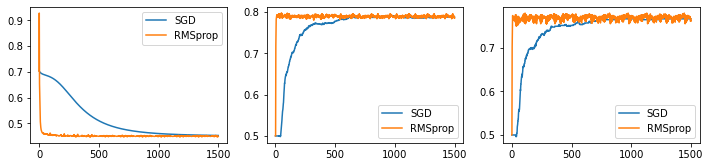

In [1229]:
fig = plt.figure(figsize=(12,2.5)); axs = [fig.add_subplot(1,3,i) for i in range(1, 4)]

for i in range(3):
    
    for df, key in zip(comp_lst, [param for param in params if param not in fail]):
        axs[i].plot(df[i], label=str(key).split('.')[-1][:-2])
    
    axs[i].legend()
        
clear_output(wait=True); plt.show()

# Calculate importance

In [1568]:
from sklearn.preprocessing import OneHotEncoder as OHE

In [1307]:
x_train, x_test = X_full_onehot.loc[split_index[0]], X_full_onehot.loc[split_index[1]]

y_train, y_test = Y.loc[split_index[0]], Y.loc[split_index[1]] 

In [1394]:
def multiple_relative_feature_importances(models_names):
    
    models = dict(sklearn.utils.all_estimators('classifier'))
    
    relative_importances = {}
    
    for i, model_name in enumerate(models_names):
        
        clear_output(wait=True); print(f'Models: {i+1}/{len(models)}')
        
        try:
            relative_importances [model_name] = relative_importance(model_name) 
        except:
            fail.append(model_name)
    
    return relative_importances

        
def relative_importance(model_name):
    
    feat_imp = {}
    avg_scr = acc_scr(y_test, models[model_name]().fit(x_train, y_train).predict(x_test))
    
    for feature in x_train.columns:        
        features= [col for col in x_train.columns if col!=feature]    
        scr = acc_scr(y_test, models[model_name]().fit(x_train[features], y_train).predict(x_test[features]))
        
        feat_imp[feature] = [scr, avg_scr-scr]
    
    return pd.DataFrame(feat_imp, index=['Scr', 'Avg diff'])
    

def importance_comparison(models_names):

    models = dict(sklearn.utils.all_estimators('classifier'))
    importances = {}
    for model_name in models_names:
        
        try:
            rfc = models[model_name]
            RFC = rfc().fit(x_train, y_train)
            scr = acc_scr(y_test, RFC.predict(x_test))
            
            try:     
                imps = RFC.feature_importances_
            except:
                imps = RFC.coef_[0]    
            
            rfc_imp = pd.Series(imps, index=x_train.columns).sort_values(ascending=False)
            importances [ str(rfc).split('.')[-1][:-2] ] = [scr, rfc_imp / rfc_imp.max()]

        except:
            fail.append(RFC)

    return importances

def plot_implit_importances(importances):
    
    n_models = len(importances)

    n_rows = n_models//3
    if n_models%3 != 0 : n_rows+=1

    fig = plt.figure(figsize=(12, 2.7*n_rows))
    axs = [fig.add_subplot(n_rows, 3, i) for i in range(1, n_models+1)]

    for i, key in enumerate(importances.keys()):
        scr, series = importances[key][0], importances[key][1]
        series.plot.bar(title=key + f' - acc: {round(scr*100, 1)}%', ax=axs[i])

    fig.tight_layout(); plt.show()

def plot_relative_importances(importances):
    
    n_models = len(importances)

    n_rows = n_models//3
    if n_models%3 != 0 : n_rows+=1

    fig = plt.figure(figsize=(12, 2.7*n_rows))
    axs = [fig.add_subplot(n_rows, 3, i) for i in range(1, n_models+1)]

    for i, key in enumerate(importances.keys()):
        
        dic = importances[key].loc['Avg diff'].sort_values(ascending=False).plot.bar(title=key, ax=axs[i])
        
    fig.tight_layout(); plt.show()

C:\Users\luisr\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:101: FutureWarning: Attribute coef_ was deprecated in version 0.24 and will be removed in 1.1 (renaming of 0.26).
  warnings.warn(msg, category=FutureWarning)
C:\Users\luisr\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\luisr\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\luisr\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\luisr\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the n

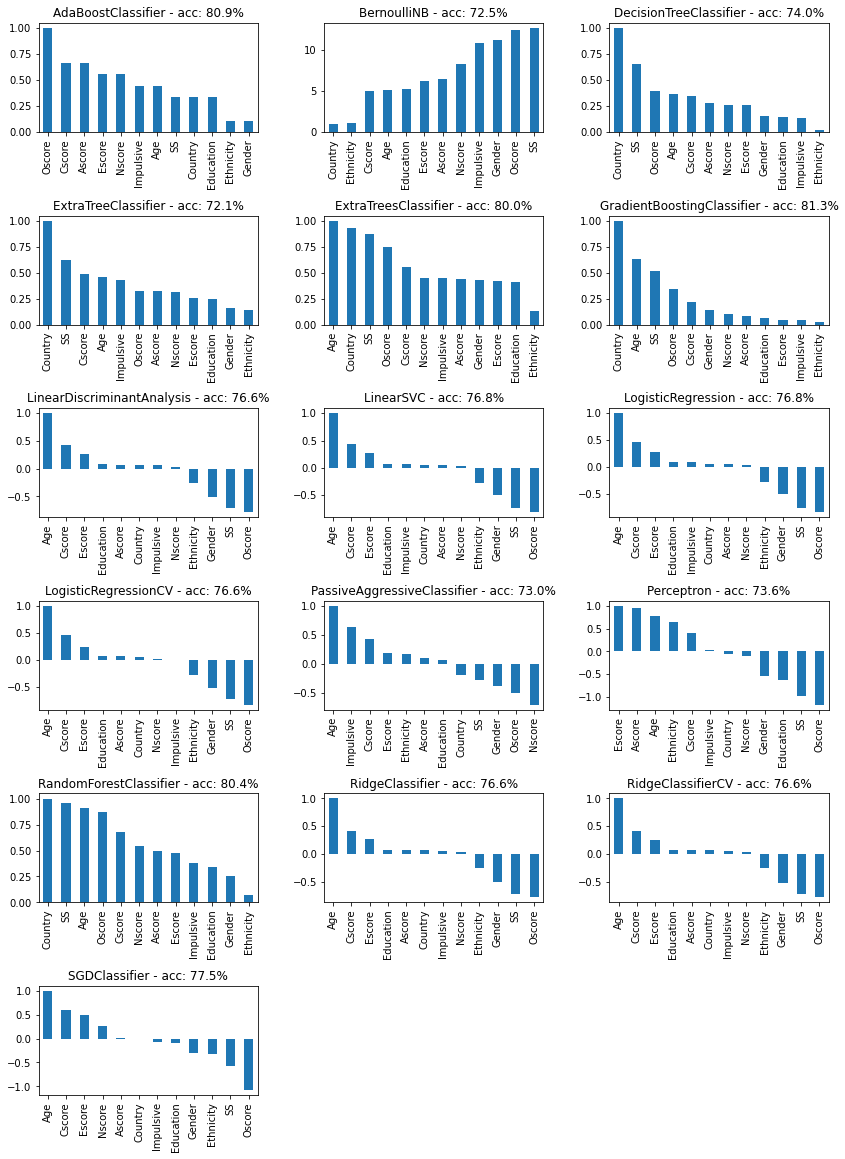

In [1366]:
plot_implicit_importances(importance_comparison(models_names=models.keys()))

Models: 41/41


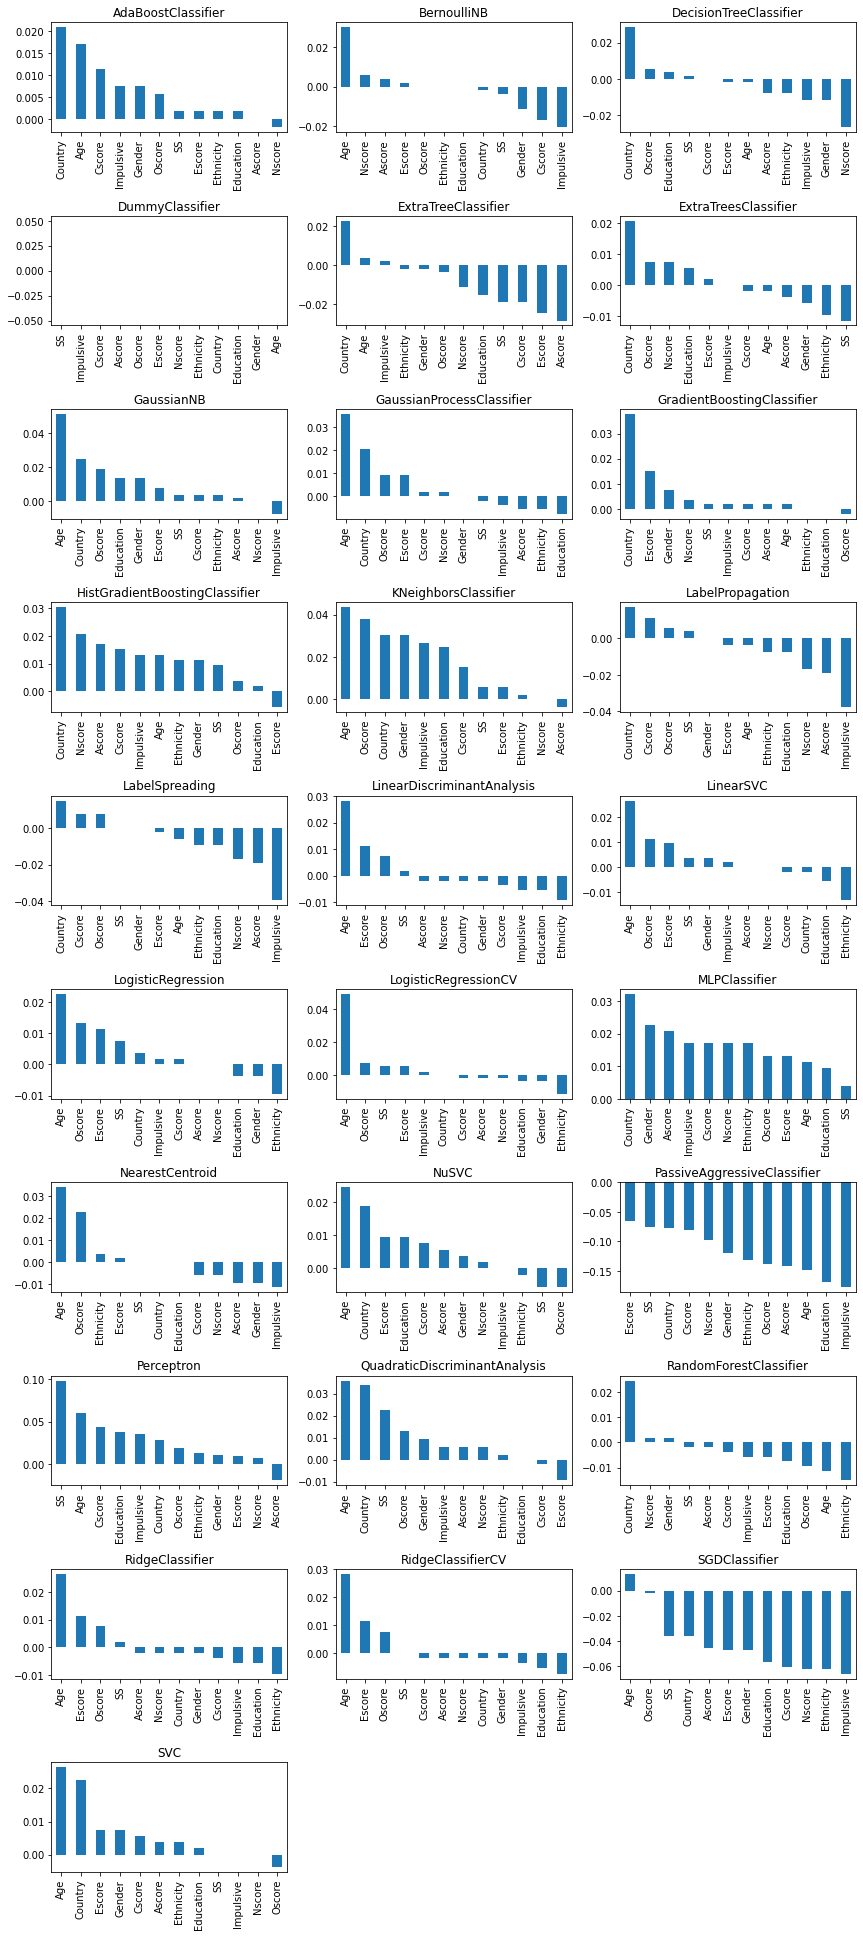

In [1404]:
rel_imps = multiple_relative_feature_importances(models_names=models.keys())

plot_relative_importances(rel_imps)

### Conclusões

Personality Traces that matters most when predicting wether an individual will ever experiment with cannabis are the Openess and the conscientiousness traces.

# Test Model of the two/three most important features

In [110]:
selected_features = [
    #                 'Age',
     #                'Country',
                     'SS',
                     'Oscore',
                     'Cscore',
                   ]

In [111]:
X_sel = X_norm[selected_features]

x_train, x_test = X_sel.loc[split_index[0]], X_sel.loc[split_index[1]]
y_train, y_test = Y.loc[split_index[0]], Y.loc[split_index[1]] 

train_data = Load_Data(x_train.values, y_train.to_frame().values)
test_data = Load_Data(x_test.values, y_test.to_frame().values)

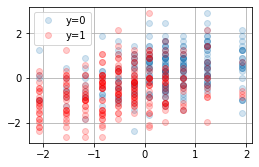

In [112]:
test_data.plot_2d([0,1], alpha=.2, figsize=(4,2.5)); # test_data.plot_2d([0,1])

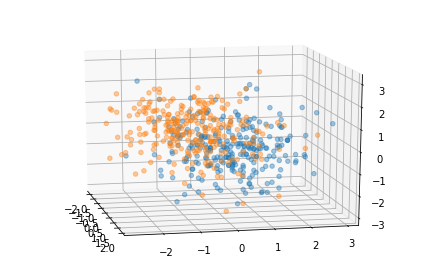

In [113]:
test_data.plot_3d([0,1,2], angle_factor=24, alpha=0.4, figsize=(6,4))

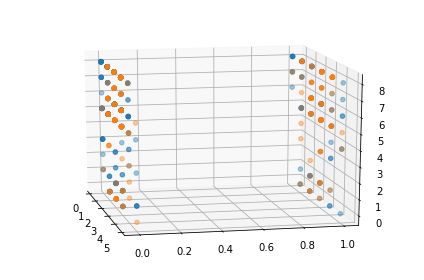

In [126]:
train_data.plot_3d([0,1,2], angle_factor=24, alpha=0.4, figsize=(6,4))

### Creating Model

In [114]:
torch.manual_seed(1)

In [115]:
n_categories = len(np.unique(train_data.y))
n_features = len(train_data.x[0])

Layers = [n_features, 36, n_categories-1]; Layers

[3, 36, 1]

In [116]:
#model = Shallow_NN(n_features, 36, n_categories-1)

model = Deep_NN(Layers)

In [117]:
learning_rate = 0.1

criterion = nn.BCELoss()

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.4)

train_loader = DataLoader(dataset=train_data, batch_size=train_data.len, shuffle=True)
#test_loader = DataLoader(dataset=test_data, batch_size=1, shuffle=True)

### Training Model Parameters

Epoch: 51/100


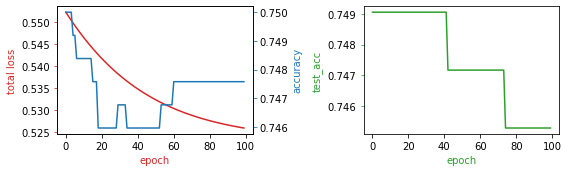

In [119]:
# Using the training function train the model on 500 epochs
LOSS, ACC, test_ACC = train(train_data, model, criterion, train_loader, optimizer, epochs=100, test_data=test_data, plot=True)

# Model Visualization

In [134]:
xx = train_data.x[:,0]
yy = train_data.x[:,1]
zz = train_data.x[:,2]

n=14

xss = np.linspace(xx.min(), xx.max(), n)
yss = np.linspace(yy.min(), yy.max(), n)
zss = np.linspace(zz.min(), zz.max(), n)

xs, ys, zs = np.meshgrid(xss, yss, zss)
XX = torch.Tensor(np.c_[xs.ravel(), ys.ravel(), zs.ravel()])
y_hat = (model(XX).detach().numpy()>0.5)+0

c = list(map(lambda x: 'blue' if x[0]==0 else 'red', train_data.y))

XX_df = pd.DataFrame(XX)
x_0 = XX_df.iloc[y_hat.reshape(n**3)==0]
x_1 = XX_df.iloc[y_hat.reshape(n**3)==1]

In [135]:
dists = []; cnt=0
for idx_0, dot1 in zip(x_0.index, x_0.values):
    cnt+=1
    if cnt in range(0, len(x_0), 15): 
        clear_output(wait=True); print(f'{cnt}/{len(x_0)}')

    for idx_1, dot2 in zip(x_1.index, x_1.values):
        
        if i in range(25, len(x_0), 25): 
            clear_output(wait=True); print(f'{i}/{len(x_0)}')
        
        dists.append( [idx_0, idx_1, ( ( (dot1[0]-dot2[0])**2 + (dot1[1]-dot2[1])**2 + (dot1[2]-dot2[2])**2 )**0.5).item() ] )

1245/1255


In [145]:
dists_df = pd.DataFrame(dists, columns=['Point 1', 'Point 2', 'Distance'])

percent_df = dists_df[dists_df['Distance']<np.percentile(dists_df['Distance'], q=.01)]

points = np.unique(percent_df['Point 1'].tolist() + percent_df['Point 2'].tolist())

xd, yd, zd = [XX[points][:, i] for i in [0,1,2]]

In [146]:
len(xd), len(dists_df)

(256, 1868695)

In [ ]:

for angle in range(0,360,10):
    
    fig = plt.figure(figsize=(7,5));
    ax=fig.add_subplot(projection='3d')

    ax.scatter(xs, ys, zs, c=y_hat, alpha=.2)
    #ax.scatter(xx, yy, zz, c=c, alpha=.3)
    ax.view_init(angle/9, angle)
    
    plt.show()
    plt.pause(.1)
    #if input('Exit?')=='True': break
    clear_output(wait=True)


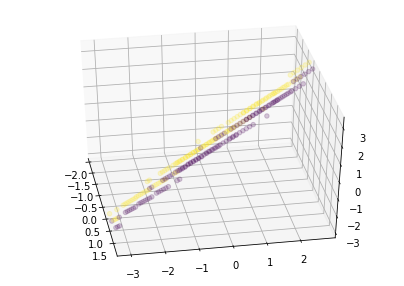

In [147]:

for angle in range(0,360,10):
    
    fig = plt.figure(figsize=(7,5));
    ax=fig.add_subplot(projection='3d')

    ax.scatter(xd, yd, zd, c=y_hat[points], alpha=.2)
    #ax.scatter(xx, yy, zz, c=c, alpha=.3)
    ax.view_init(angle/9, angle)
    
    ax.set(xlim=(xx.min(), xx.max()),
           ylim=(yy.min(), yy.max()),
           zlim=(zz.min(), zz.max())
          )
    
    plt.show()
    plt.pause(.1)
    #if input('Exit?')=='True': break
    clear_output(wait=True)


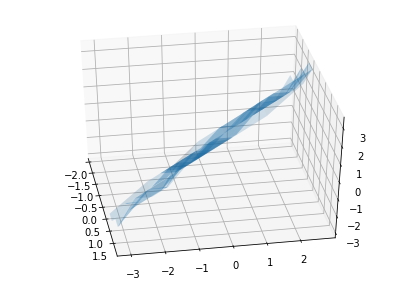

In [148]:

for angle in range(0,360,10):
    
    fig = plt.figure(figsize=(7,5));
    ax=fig.add_subplot(projection='3d')

    ax.plot_trisurf(xd, yd, zd, alpha=.2)
    #ax.scatter(xx, yy, zz, c=c, alpha=.3)
    ax.view_init(angle/9, angle)
    
    ax.set(xlim=(xx.min(), xx.max()),
           ylim=(yy.min(), yy.max()),
           zlim=(zz.min(), zz.max())
          )
    
    plt.show()
    plt.pause(.1)
    #if input('Exit?')=='True': break
    clear_output(wait=True)


In [126]:
from sklearn.linear_model import LinearRegression as lr

In [127]:
LR = lr().fit(XX[points][:, :2], XX[points][:, 2])

a1, a2 = LR.coef_

b = LR.intercept_

xi, yi = np.meshgrid(xss, yss)

zhat = ( a1*xi.ravel() + a2*yi.ravel() + b ).reshape(xi.shape)

In [554]:
Xt = test_data.x

for angle in range(0,350,10):
    
    fig = plt.figure(figsize=(7,5));
    ax=fig.add_subplot(projection='3d')

    ax.scatter(Xt[:, 0], Xt[:, 1], Xt[:, 2], c=test_data.y, alpha=.3)
    #ax.plot_wireframe(xi, yi, zhat, alpha=.3)
    ax.plot_trisurf(xd, yd, zd, alpha=.2)

    ax.view_init(angle/16, angle)
    
    ax.set(xlim=(xx.min(), xx.max()),
           ylim=(yy.min(), yy.max()),
           zlim=(zz.min(), zz.max())
          )
    
    plt.show()
    plt.pause(.1)
    #if input('Exit?')=='True': break
    clear_output(wait=True)


NameError: name 'test_data' is not defined

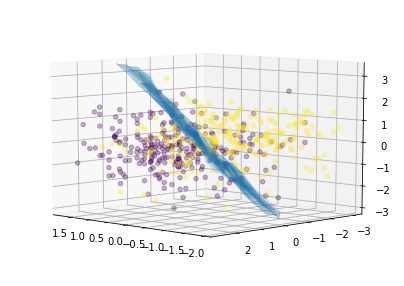

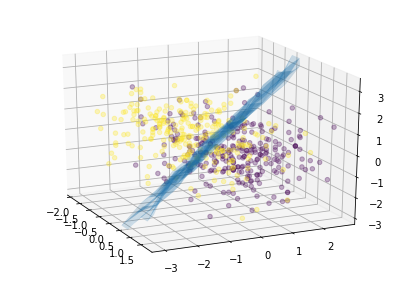

In [190]:
Xt = test_data.x

for angle in [134,335]:
    
    fig = plt.figure(figsize=(7,5));
    ax=fig.add_subplot(projection='3d')

    ax.scatter(Xt[:, 0], Xt[:, 1], Xt[:, 2], c=test_data.y, alpha=.3)
    #ax.plot_wireframe(xi, yi, zhat, alpha=.3)
    ax.plot_trisurf(xd, yd, zd, alpha=.2)

    ax.view_init(angle/16, angle)
    
    ax.set(xlim=(xx.min(), xx.max()),
           ylim=(yy.min(), yy.max()),
           zlim=(zz.min(), zz.max())
          )
    
    plt.show()
    plt.pause(.1)
    #if input('Exit?')=='True': break
    #clear_output(wait=True)


### Modeling Using Drug Columns

### Decision Region 3D

### Decision Region 2D

In [ ]:
# Plot the data with decision boundaries
plot_decision_regions_2class(model, train_data, index=[0,1])

In [484]:
X_norm.values[:, 0]

array([-0.27051098,  0.51235029, -1.05337224, ..., -0.27051098,
       -1.05337224, -1.05337224])

In [486]:
data_set = train_data

In [488]:
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#00AAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])

X = data_set.x.numpy()
y = data_set.y.numpy()
h = .02

x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 

xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))

No handles with labels found to put in legend.


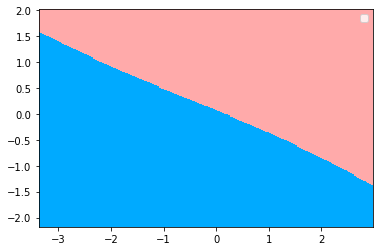

In [517]:
XX = torch.Tensor(np.c_[xx.ravel(), yy.ravel()])

yhat = np.logical_not((model(XX)[:, 0] > 0.5).numpy()).reshape(xx.shape)

plt.pcolormesh(xx, yy, yhat, cmap=cmap_light, shading='auto')

#plt.plot(X[y[:, 0] == 0, 0], X[y[:, 0] == 0, 1], 'o', label='y=0')
#plt.plot(X[y[:, 0] == 1, 0], X[y[:, 0] == 1, 1], 'ro', label='y=1')

#plt.title("decision region")
plt.legend()

In [612]:
from sklearn.feature_selection import RFE, RFECV